# 0. Verify GPU/Install Transformers

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

!pip install transformers seqeval[gpu]
!pip install torch 

# 1. Import Libraries




In [3]:
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cpu


# 2. Import Data


#Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

In [2]:
#read in annotated data
ner_dataset = pd.read_csv("nb/ner_model_baseline.ipynb",encoding='unicode-escape',on_bad_lines='skip')
ner = pd.read_csv("nb/ner_model_baseline.ipynb",encoding='unicode-escape',on_bad_lines='skip')

NameError: name 'pd' is not defined

# 3. Pre-process Data 


In [ ]:
ner_dataset.count()

Sentence #      47959
Word          1048575
POS           1048575
Tag           1048575
dtype: int64

In [ ]:
frequencies = ner_dataset['Tag'].value_counts()
frequencies

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [ ]:
#count entities 
tags = {}
for tag, count in zip(frequencies.index, frequencies):
  if tag != 'O':
    if tag[2:5] not in tags.keys():
      tags[tag[2:5]] = count
    else:
      tags[tag[2:5]] += count

tags

{'geo': 45058,
 'tim': 26861,
 'org': 36927,
 'per': 34241,
 'gpe': 16068,
 'art': 699,
 'eve': 561,
 'nat': 252}

In [ ]:
#remove nat, eve, art

ner_dataset = data = ner_dataset[~ner_dataset.Tag.isin(['B-nat','B-eve', 'B-art','I-nat','I-eve', 'I-art'])]
ner_dataset['Tag'].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
I-gpe       198
Name: Tag, dtype: int64

In [ ]:
#create dictionary for tags 
labels_to_ids = {k:v for v, k in enumerate(ner_dataset.Tag.unique())}
id_to_labels = {v: k for v, k in enumerate(data.Tag.unique())}

labels_to_ids

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'I-per': 8,
 'I-gpe': 9,
 'I-tim': 10}

In [ ]:
#replace NaNs
ner_dataset = ner_dataset.fillna(method='ffill')
ner_dataset.head(5)



,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [ ]:
#group by sentence
data = ner_dataset.groupby(ner_dataset['Sentence #'])

#create sentence column
ner_dataset['sentence'] =data['Word'].transform(lambda x:' '.join(x))

#create sentence tags column
ner_dataset['sentence_tags'] = data['Tag'].transform(lambda x:','.join(x))

ner_dataset.tail(10)

,Sentence #,Word,POS,Tag,sentence,sentence_tags
1048565,Sentence: 47958,impact,NN,O,They say not all of the rockets exploded upon ...,"O,O,O,O,O,O,O,O,O,O,O"
1048566,Sentence: 47958,.,.,O,They say not all of the rockets exploded upon ...,"O,O,O,O,O,O,O,O,O,O,O"
1048567,Sentence: 47959,Indian,JJ,B-gpe,Indian forces said they responded to the attack,"B-gpe,O,O,O,O,O,O,O"
1048568,Sentence: 47959,forces,NNS,O,Indian forces said they responded to the attack,"B-gpe,O,O,O,O,O,O,O"
1048569,Sentence: 47959,said,VBD,O,Indian forces said they responded to the attack,"B-gpe,O,O,O,O,O,O,O"
1048570,Sentence: 47959,they,PRP,O,Indian forces said they responded to the attack,"B-gpe,O,O,O,O,O,O,O"
1048571,Sentence: 47959,responded,VBD,O,Indian forces said they responded to the attack,"B-gpe,O,O,O,O,O,O,O"
1048572,Sentence: 47959,to,TO,O,Indian forces said they responded to the attack,"B-gpe,O,O,O,O,O,O,O"
1048573,Sentence: 47959,the,DT,O,Indian forces said they responded to the attack,"B-gpe,O,O,O,O,O,O,O"
1048574,Sentence: 47959,attack,NN,O,Indian forces said they responded to the attack,"B-gpe,O,O,O,O,O,O,O"


In [ ]:
ner_dataset = ner_dataset[["sentence", "sentence_tags"]].drop_duplicates().reset_index(drop=True)
ner_dataset.head()

,sentence,sentence_tags
0,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
1,Families of soldiers killed in the conflict jo...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-per,O,O,..."
2,They marched from the Houses of Parliament to ...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,I-geo,O"
3,"Police put the number of marchers at 10,000 wh...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
4,The protest comes on the eve of the annual con...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,O,O,B-org,I-org,O,..."


In [ ]:
len(ner_dataset)

47571

# 4.Transform Data for Use in Model

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 1
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
#create a dataset object for use in BERT NER model
class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
      

  def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        sentence = self.data.sentence.to_numpy()[index]  
        sentence_tags = self.data.sentence_tags.iloc[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [labels_to_ids[label] for label in sentence_tags] 

        #labels = labels.to_numpy()
        
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

  

In [ ]:
#split into training and testing 

from sklearn.model_selection import train_test_split
  
train_set, test_set = train_test_split(ner_dataset, train_size = 0.8, random_state = 42)


In [ ]:
training_set = dataset(train_set, tokenizer, MAX_LEN)
testing_set = dataset(test_set, tokenizer, MAX_LEN)

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)



# 5. Train Model for 1 epoch


In [ ]:
#instantiate Bert for NER model and send to gpu 
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids))
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#define the optimizer 
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
#training function 
def train(training_model, epochs):

  nb_batches = 0
  nb_tr_sentences = 0
  avg_loss = 0
  tr_loss, tr_accuracy = 0, 0
  nb_tr_examples, nb_tr_steps = 0, 0
  loss_per_batch = []
  loss_per_epoch = []
  acc_per_batch = []
  acc_per_epoch = []

  model = training_model

  for idx, batch in enumerate(training_loader):
    
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    
    ids = batch['input_ids'].to(device, dtype = torch.long)
    mask = batch['attention_mask'].to(device, dtype = torch.long)
    labels = batch['labels'].to(device, dtype = torch.long)

    loss = model(input_ids=ids, attention_mask=mask, labels=labels)[0]
    tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels)[1]

    #import pdb
    #pdb.set_trace()
    
    tr_loss += loss.item()
   

    nb_tr_steps += 1
    nb_tr_sentences += labels.size(0)

    nb_batches += 1
  
    
    if idx % 100==0:
        loss_step = tr_loss/nb_tr_steps
        print(f"Training loss per 100 training steps: {loss_step}")
        
    # compute training accuracy
    flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
    active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
    flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
    
    # only compute accuracy at active labels
    active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
    #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
    
    labels = torch.masked_select(flattened_targets, active_accuracy)
    predictions = torch.masked_select(flattened_predictions, active_accuracy)
    
    tr_labels.extend(labels)
    tr_preds.extend(predictions)

    tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
    tr_accuracy += tmp_tr_accuracy

    # gradient clipping
    torch.nn.utils.clip_grad_norm_(
        parameters=model.parameters(), max_norm=MAX_GRAD_NORM
    )
    
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    loss_per_batch.append(epoch_loss)

    batch_accuracy = tr_accuracy / nb_tr_steps
    acc_per_batch.append(batch_accuracy)

    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")
    print(f"Number of batches: {nb_batches}")  
    print(f"Number of Sentences Trained on: {nb_tr_sentences}")  

  loss_per_epoch.append(epoch_loss)
  acc_per_epoch.append(batch_accuracy)

  return (loss_per_batch, loss_per_epoch, acc_per_batch, acc_per_epoch)

In [ ]:
#train model

for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    batch_loss,epoch_loss, batch_acc, epoch_acc = train(model, epoch)


Streaming output truncated to the last 5000 lines.
Training loss epoch: 0.3137761241027268
Training accuracy epoch: 1035.3125
Number of batches: 1133
Number of Sentences Trained on: 18128
Training loss epoch: 0.31388356216823454
Training accuracy epoch: 1036.1875
Number of batches: 1134
Number of Sentences Trained on: 18144
Training loss epoch: 0.3138197646086568
Training accuracy epoch: 1037.125
Number of batches: 1135
Number of Sentences Trained on: 18160
Training loss epoch: 0.31367090219323535
Training accuracy epoch: 1038.0625
Number of batches: 1136
Number of Sentences Trained on: 18176
Training loss epoch: 0.31371692804129847
Training accuracy epoch: 1038.9375
Number of batches: 1137
Number of Sentences Trained on: 18192
Training loss epoch: 0.3136298682471911
Training accuracy epoch: 1039.875
Number of batches: 1138
Number of Sentences Trained on: 18208
Training loss epoch: 0.31364883584010433
Training accuracy epoch: 1040.8125
Number of batches: 1139
Number of Sentences Traine

In [ ]:
#Plot training loss per batch
import matplotlib.pyplot as plt

def plot_metric(metric, title):
    x0 = list(range(1, len(metric) + 1))
    plt.figure(figsize =(10, 5))
    plt.plot(x0, metric)
    plt.title(title)
    plt.show()



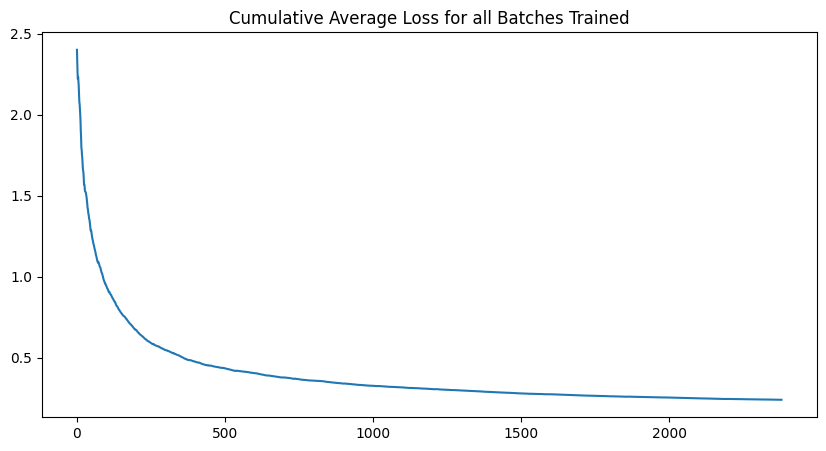

In [ ]:
plot_metric(batch_loss, 'Cumulative Average Loss for all Batches Trained')

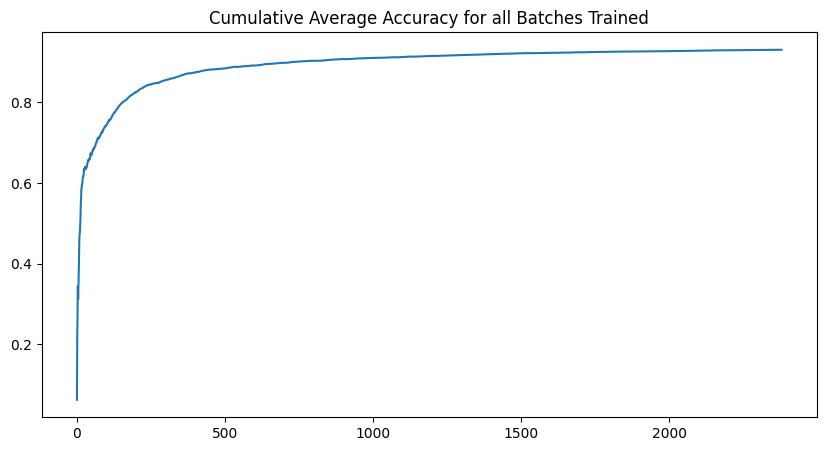

In [ ]:
plot_metric(batch_acc, 'Cumulative Average Accuracy for all Batches Trained')

In [ ]:
#evaluate model
def valid(eval_model, testing_loader):
    model = eval_model

    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    loss_per_epoch, acc_per_epoch = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss = model(input_ids=ids, attention_mask=mask, labels=labels)[0]
            eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels)[1]
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [id_to_labels[id.item()] for id in eval_labels]
    predictions = [id_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps

    loss_per_epoch.append(eval_loss)
    acc_per_epoch.append(eval_accuracy)
    
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, loss_per_epoch, acc_per_epoch

In [ ]:
labels, predictions, epoch_loss, epoch_accuracy = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.16198831796646118
Validation loss per 100 evaluation steps: 0.15873854809744967
Validation loss per 100 evaluation steps: 0.1711404803232174
Validation loss per 100 evaluation steps: 0.16799391192489263
Validation loss per 100 evaluation steps: 0.17055855031900963
Validation loss per 100 evaluation steps: 0.16958752136534366
Validation Loss: 0.17052917142570834
Validation Accuracy: 0.9466482047364401


In [ ]:
from sklearn import metrics

print(metrics.classification_report(labels, predictions))

              precision    recall  f1-score   support

       B-geo       0.76      0.86      0.81       650
       B-gpe       0.89      0.91      0.90       603
       B-org       0.79      0.58      0.67       534
       B-per       0.91      0.93      0.92       796
       B-tim       0.93      0.80      0.86        99
           O       0.99      0.99      0.99      6833

    accuracy                           0.95      9515
   macro avg       0.88      0.85      0.86      9515
weighted avg       0.95      0.95      0.95      9515



In [ ]:
def perform_NER(model, text):

  
  NER_model = model
  sentence = text

  '''

  '''

  inputs = tokenizer(sentence.split(),
                      return_offsets_mapping=True, 
                      padding='max_length', 
                      truncation=True, 
                      max_length=MAX_LEN,
                      return_tensors="pt")

  # move to gpu
  ids = inputs["input_ids"].to(device)
  mask = inputs["attention_mask"].to(device)
  # forward pass
  outputs = NER_model(ids, attention_mask=mask)
  logits = outputs[0]

  active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
  flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

  #import pdb 
  #pdb.set_trace()

  tokens = tokenizer.convert_ids_to_tokens(ids.reshape(-1).tolist())
  token_predictions = [id_to_labels[i] for i in flattened_predictions.cpu().numpy()]
  wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

  prediction = []

  for token_pred, mapping in zip(wp_preds, inputs["offset_mapping"].view(len(wp_preds),2).tolist()):

    
    #only predictions on first word pieces are important
    if mapping[0] == 0 and mapping[1] != 0:
      prediction.append(token_pred[1])
    else:
      continue

  print(sentence.split())
  print(prediction)

In [ ]:
sentence = "John Smith is a software engineer at Microsoft Corporation. He lives in Seattle, "\
            "Washington and enjoys hiking in the nearby mountains. "\
            "He has a Bachelor’s degree in Computer Science from the University of Washington."

perform_NER(model, sentence)

['John', 'Smith', 'is', 'a', 'software', 'engineer', 'at', 'Microsoft', 'Corporation.', 'He', 'lives', 'in', 'Seattle,', 'Washington', 'and', 'enjoys', 'hiking', 'in', 'the', 'nearby', 'mountains.', 'He', 'has', 'a', 'Bachelor’s', 'degree', 'in', 'Computer', 'Science', 'from', 'the', 'University', 'of', 'Washington.']
['B-per', 'B-per', 'O', 'O', 'O', 'O', 'O', 'B-org', 'B-org', 'O', 'O', 'O', 'B-geo', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo']


In [ ]:
def save_model(m, dir):
  
  import os

  model = m
  directory = dir

  if not os.path.exists(directory):
      os.makedirs(directory)

  # save vocabulary of the tokenizer
  tokenizer.save_vocabulary(directory)
  # save the model weights and its configuration file
  model.save_pretrained(directory)


In [ ]:
save_model(model, "model")

# 6. Train Model for 4 epochs

In [ ]:
#instantiate Bert for NER model and send to gpu 
model2 = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids))
model2.to(device)

#define the optimizer 
optimizer = torch.optim.Adam(params=model2.parameters(), lr=LEARNING_RATE)
EPOCHS = 4

train_loss, train_acc = [], []

for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    batch_loss,epoch_loss, batch_acc, epoch_acc = train(model2, epoch)

    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    import pdb
    #pdb.set_trace()



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

Streaming output truncated to the last 5000 lines.
Training loss epoch: 0.07788566605672725
Training accuracy epoch: 1103.4375
Number of batches: 1133
Number of Sentences Trained on: 18128
Training loss epoch: 0.07790315446066687
Training accuracy epoch: 1104.375
Number of batches: 1134
Number of Sentences Trained on: 18144
Training loss epoch: 0.07784784879911863
Training accuracy epoch: 1105.375
Number of batches: 1135
Number of Sentences Trained on: 18160
Training loss epoch: 0.07784394625324098
Training accuracy epoch: 1106.3125
Number of batches: 1136
Number of Sentences Trained on: 18176
Training loss epoch: 0.07782224147278928
Training accuracy epoch: 1107.3125
Number of batches: 1137
Number of Sentences Trained on: 18192
Training loss epoch: 0.07778012476670589
Training accuracy epoch: 1108.3125
Number of batches: 1138
Number of Sentences Trained on: 18208
Training loss epoch: 0.07771570974227271
Training accuracy epoch: 1109.3125
Number of batches: 1139
Number of Sentences Tra

In [ ]:
epoch_acc

[0.973150483396385]

In [ ]:
val_loss, val_acc = [], []

for epoch in range(EPOCHS):

  print(f"Validation epoch: {epoch + 1}")
  labels, predictions, val_epoch_loss, val_epoch_accuracy = valid(model2, testing_loader)

  val_loss.append(val_epoch_loss)
  val_acc.append(val_epoch_accuracy)


Validation epoch: 1
Validation loss per 100 evaluation steps: 0.0060434709303081036
Validation loss per 100 evaluation steps: 0.1869116087229738
Validation loss per 100 evaluation steps: 0.19028415911094243
Validation loss per 100 evaluation steps: 0.1878119059244675
Validation loss per 100 evaluation steps: 0.18445996161996783
Validation loss per 100 evaluation steps: 0.1900999593762718
Validation Loss: 0.18632638693626719
Validation Accuracy: 0.9453304048892284
Validation epoch: 2
Validation loss per 100 evaluation steps: 0.5281784534454346
Validation loss per 100 evaluation steps: 0.18556884961320308
Validation loss per 100 evaluation steps: 0.1909793709738954
Validation loss per 100 evaluation steps: 0.18035187978089395
Validation loss per 100 evaluation steps: 0.18221794982746178
Validation loss per 100 evaluation steps: 0.18372959348962395
Validation Loss: 0.18642267470655008
Validation Accuracy: 0.9453304048892284
Validation epoch: 3
Validation loss per 100 evaluation steps: 0.0

In [ ]:
#plot metrics per epoch
def plot_metric_per_epoch(metric, val_metric, n_epochs, title):
  
    x0 = list(range(1, n_epochs + 1))
    plt.figure(figsize =(10, 5))
    plt.plot(x0, metric)
    plt.plot(x0, val_metric)
    plt.title(title)
    plt.show()


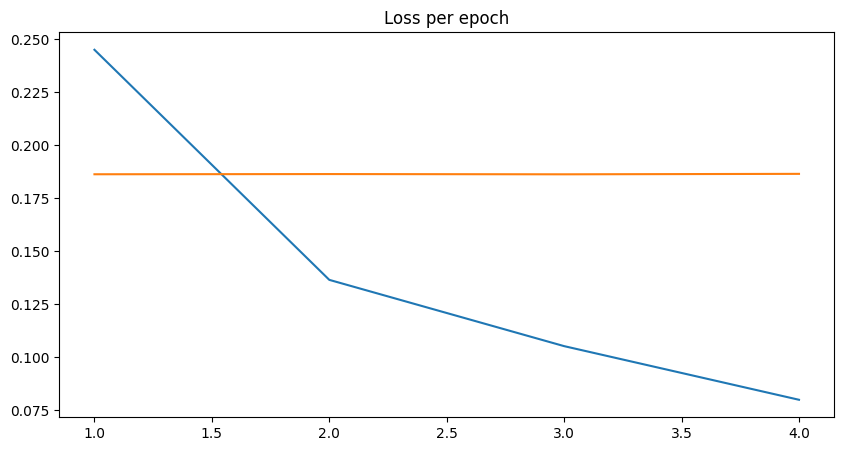

In [ ]:
plot_metric_per_epoch(train_loss, val_loss, EPOCHS, "Loss per epoch")

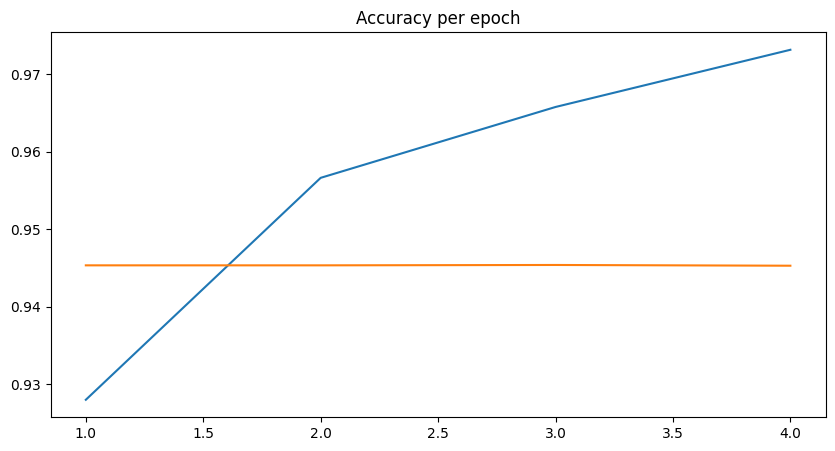

In [ ]:
plot_metric_per_epoch(train_acc, val_acc, EPOCHS, "Accuracy per epoch")

In [ ]:
from sklearn import metrics

print(metrics.classification_report(labels, predictions))

              precision    recall  f1-score   support

       B-geo       0.73      0.89      0.80       650
       B-gpe       0.97      0.88      0.92       603
       B-org       0.68      0.67      0.68       534
       B-per       0.94      0.91      0.92       796
       B-tim       0.85      0.87      0.86        99
           O       0.99      0.98      0.99      6833

    accuracy                           0.95      9515
   macro avg       0.86      0.87      0.86      9515
weighted avg       0.95      0.95      0.95      9515



In [ ]:
perform_NER(model2, sentence)

['John', 'Smith', 'is', 'a', 'software', 'engineer', 'at', 'Microsoft', 'Corporation.', 'He', 'lives', 'in', 'Seattle,', 'Washington', 'and', 'enjoys', 'hiking', 'in', 'the', 'nearby', 'mountains.', 'He', 'has', 'a', 'Bachelor’s', 'degree', 'in', 'Computer', 'Science', 'from', 'the', 'University', 'of', 'Washington.']
['B-per', 'B-per', 'O', 'O', 'O', 'O', 'O', 'B-org', 'B-org', 'O', 'O', 'O', 'B-geo', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-org', 'O', 'O', 'B-org', 'O', 'B-geo']


In [ ]:
save_model(model2, "Bert NER_4_epochs")

# 7. Import Annotated Medical Data for Use in Model

1.   List item
2.   List item



---



In [ ]:
medical_file = "/content/drive/MyDrive/Colab Notebooks/Capstone/CaseReportCorpus.pickle"

%pip install bioc

from bioc import biocxml
# Deserialize ``fp`` to a BioC collection object.
with open(medical_file, 'rb') as fp:
    collection = biocxml.load(fp)
    corpus = pd.DataFarme(collection)
'''
import pickle as pkl
import pandas as pd
import os


scores = {} # scores is an empty dict already

with open(medical_file, "rb") as f:
  med_data = pkl.load(f)
    
  corpus = pd.DataFrame(med_data)
  corpus.to_csv(medical_file)
  scores
'''

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26114 sha256=47d6023e94d25d283dececc65db146a865719c1af667555807e5867a2be64583
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree


XMLSyntaxError: ignored

# 8. Train and Validate Model on Medical Data